# Overal-Survival KM

Download [Pancan/TCGA](https://www.cell.com/pb-assets/consortium/pancanceratlas/pancani3/index.html), [Pancan/TARGET](https://www.cancer.gov/ccg/research/genome-sequencing/target/about) and [GTEX](https://gtexportal.org) clinical labels and RNA-Seq genes expression computed by the [Toil recompute](https://xenabrowser.net/datapages/?hub=https://toil.xenahubs.net:443) from [Xena](https://xenabrowser.net).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import lifelines  # Bibliothèque pour les analyses de survie


# Switch to a scratch data directory so all paths are local
# os.makedirs(os.path.expanduser("/Users/marion/Documents/ADLIN/Projet_IntegratiOMICS/Données/pancan-gtex-target"), exist_ok=True)
# os.chdir(os.path.expanduser("/Users/marion/Documents/ADLIN/Projet_IntegratiOMICS/Données/pancan-gtex-target"))

## Download TCGA survival labels

In [2]:
# !wget -q -N https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp

In [3]:
survival_labels_tcga = pd.read_table(
    "Survival_SupplementalTable_S1_20171025_xena_sp", 
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")

In [4]:
pd.set_option('display.max_columns', None)
survival_labels_tcga.head()

,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0001-01,TCGA-02-0001,GBM,44,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2002,NaN,-16179,Dead,WITH TUMOR,279,358,NaN,Recurrence,NaN,NaN,137,NaN,NaN,NaN,1,358,1,358,NaN,NaN,1,137,NaN
TCGA-02-0003-01,TCGA-02-0003,GBM,50,MALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2003,NaN,-18341,Dead,WITH TUMOR,144,144,NaN,Recurrence,NaN,NaN,40,NaN,NaN,NaN,1,144,1,144,NaN,NaN,1,40,NaN
TCGA-02-0006-01,TCGA-02-0006,GBM,56,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2002,NaN,-20516,Dead,WITH TUMOR,558,558,NaN,Recurrence,NaN,NaN,302,NaN,NaN,NaN,1,558,1,558,NaN,NaN,1,302,NaN
TCGA-02-0007-01,TCGA-02-0007,GBM,40,FEMALE,WHITE,NaN,NaN,Treated primary GBM,NaN,2002,NaN,-14806,Dead,WITH TUMOR,705,705,NaN,Progression of Disease,NaN,NaN,518,NaN,NaN,NaN,1,705,1,705,NaN,NaN,1,518,NaN
TCGA-02-0009-01,TCGA-02-0009,GBM,61,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2003,NaN,-22457,Dead,WITH TUMOR,322,322,NaN,Progression of Disease,NaN,NaN,264,NaN,NaN,NaN,1,322,1,322,NaN,NaN,1,264,NaN


### TCGA survival labels exploration

In [5]:
num_rows, num_cols = survival_labels_tcga.shape
print("Nombre de lignes :", num_rows)
print("Nombre de colonnes :", num_cols)

Nombre de lignes : 12591
Nombre de colonnes : 33


In [6]:
# Voir https://ucsc-xena.gitbook.io/project/local-xena-hub/km-plots-using-data-from-a-local-xena-hub  
column_names = survival_labels_tcga.columns
column_names

Index(['_PATIENT', 'cancer type abbreviation',
       'age_at_initial_pathologic_diagnosis', 'gender', 'race',
       'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type',
       'histological_grade', 'initial_pathologic_dx_year', 'menopause_status',
       'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to',
       'death_days_to', 'cause_of_death', 'new_tumor_event_type',
       'new_tumor_event_site', 'new_tumor_event_site_other',
       'new_tumor_event_dx_days_to', 'treatment_outcome_first_course',
       'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time',
       'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'],
      dtype='object')

### Drop NA in OS and OS.time

In [7]:
survival_labels_tcga_na = survival_labels_tcga.dropna(subset=['OS', 'OS.time'])
survival_labels_tcga_na

,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0001-01,TCGA-02-0001,GBM,44,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2002,NaN,-16179,Dead,WITH TUMOR,279,358,NaN,Recurrence,NaN,NaN,137,NaN,NaN,NaN,1,358,1,358,NaN,NaN,1,137,NaN
TCGA-02-0003-01,TCGA-02-0003,GBM,50,MALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2003,NaN,-18341,Dead,WITH TUMOR,144,144,NaN,Recurrence,NaN,NaN,40,NaN,NaN,NaN,1,144,1,144,NaN,NaN,1,40,NaN
TCGA-02-0006-01,TCGA-02-0006,GBM,56,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2002,NaN,-20516,Dead,WITH TUMOR,558,558,NaN,Recurrence,NaN,NaN,302,NaN,NaN,NaN,1,558,1,558,NaN,NaN,1,302,NaN
TCGA-02-0007-01,TCGA-02-0007,GBM,40,FEMALE,WHITE,NaN,NaN,Treated primary GBM,NaN,2002,NaN,-14806,Dead,WITH TUMOR,705,705,NaN,Progression of Disease,NaN,NaN,518,NaN,NaN,NaN,1,705,1,705,NaN,NaN,1,518,NaN
TCGA-02-0009-01,TCGA-02-0009,GBM,61,FEMALE,WHITE,NaN,NaN,Untreated primary (de novo) GBM,NaN,2003,NaN,-22457,Dead,WITH TUMOR,322,322,NaN,Progression of Disease,NaN,NaN,264,NaN,NaN,NaN,1,322,1,322,NaN,NaN,1,264,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,TCGA-ZS-A9CG,LIHC,55,MALE,WHITE,Stage II,NaN,Hepatocellular Carcinoma,G2,2013,NaN,-20100,Alive,TUMOR FREE,341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R0,0,341,0,341,0,341,0,341,NaN
TCGA-ZT-A8OM-01,TCGA-ZT-A8OM,THYM,73,FEMALE,WHITE,NaN,IIb,Thymoma; Type A,NaN,2011,NaN,-26923,Alive,TUMOR FREE,1398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1398,0,1398,NaN,NaN,0,1398,NaN
TCGA-ZU-A8S4-01,TCGA-ZU-A8S4,CHOL,52,MALE,WHITE,Stage I,NaN,Cholangiocarcinoma; intrahepatic,G3,2012,NaN,-19264,Dead,WITH TUMOR,NaN,98,NaN,Intrahepatic Recurrence,Liver,NaN,72,NaN,NaN,R0,1,98,1,98,1,72,1,72,NaN


In [8]:
# Vérifier le nombre de valeurs manquantes dans les colonnes d'intérêt
na_counts = survival_labels_tcga_na[['OS', 'OS.time']].isna().sum()
na_counts

OS         0
OS.time    0
dtype: int64

In [9]:
# Copier les colonnes d'intérêt dans un nouveau DataFrame
df_OS_OS_time = survival_labels_tcga_na[['OS', 'OS.time']].copy()

# Convertir les types de données
df_OS_OS_time["OS"] = df_OS_OS_time["OS"].astype(int).astype(bool)  # convertir en booléen
df_OS_OS_time["OS.time"] = df_OS_OS_time["OS.time"].astype(int)  # convertir en entier

In [10]:
df_OS_OS_time["OS"].astype(bool).mean()

0.33237501996486185

## KM pour tous les cancers

Text(0.5, 0, 'time $t$')

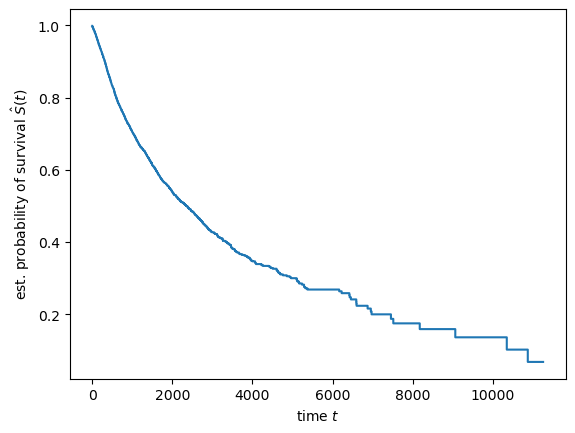

In [11]:
# Utiliser la fonction kaplan_meier_estimator
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(df_OS_OS_time["OS"], df_OS_OS_time["OS.time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## KM pour chaque type de cancer

In [12]:
import plotly.graph_objects as go

# Créer une nouvelle figure
fig = go.Figure()

for value in survival_labels_tcga_na["cancer type abbreviation"].unique():
    mask = survival_labels_tcga_na["cancer type abbreviation"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_OS_OS_time["OS"][mask],
                                                           df_OS_OS_time["OS.time"][mask])

    # Ajouter une trace de type step pour chaque type de cancer
    fig.add_trace(go.Scatter(x=time_cell, y=survival_prob_cell, mode='lines+markers',
                             name="%s (n = %d)" % (value, mask.sum())))

# Ajouter les labels pour les axes
fig.update_layout(xaxis_title='time $t$', yaxis_title='est. probability of survival $\hat{S}(t)$')

# Afficher la figure
fig.write_html("./figures/KM_pour_chaque_type_de_cancer.html")

## KM by molecular subtype

In [13]:
# !wget -q -N https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGASubtype.20170308.tsv.gz

In [14]:
molecular_subtype = pd.read_table(
    "TCGASubtype.20170308.tsv.gz", compression="gzip", 
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")

In [15]:
# molecular_subtype.head()

Merge avec les données de survie

In [16]:
merged_df = survival_labels_tcga_na.join(molecular_subtype, how='inner')
merged_df = merged_df.dropna(subset=["OS"])
merged_df = merged_df.dropna(subset=["Subtype_mRNA"])
# merged_df.head()

In [17]:
# Copier les colonnes d'intérêt dans un nouveau DataFrame
df_OS_OS_time = merged_df[['OS', 'OS.time']].copy()

# Convertir les types de données
df_OS_OS_time["OS"] = df_OS_OS_time["OS"].astype(int).astype(bool)  # convertir en booléen
df_OS_OS_time["OS.time"] = df_OS_OS_time["OS.time"].astype(int)  # convertir en entier

In [18]:
df_OS_OS_time["OS"].astype(bool).mean()

0.33842070338420704

In [19]:
import plotly.graph_objects as go
import os

# Obtenir les types de cancer uniques
unique_cancer_types = survival_labels_tcga_na["cancer type abbreviation"].unique()

for cancer_type in unique_cancer_types:
    # Sélectionner uniquement les données pour le type de cancer actuel
    cancer_data = merged_df[merged_df["cancer type abbreviation"] == cancer_type]

    # Obtenir les sous-types moléculaires uniques pour ce type de cancer
    unique_subtypes = cancer_data["Subtype_mRNA"].unique()
    
    # Créer une nouvelle figure pour chaque type de cancer
    fig = go.Figure()
    
    for subtype in unique_subtypes:
        # Créer un masque pour sélectionner uniquement les données pour le sous-type moléculaire actuel
        mask = (cancer_data["Subtype_mRNA"] == subtype).reindex(df_OS_OS_time.index).fillna(False)
        
        # Calculer l'estimateur de survie de Kaplan-Meier pour ce sous-type de cancer
        time, survival_prob = kaplan_meier_estimator(df_OS_OS_time["OS"][mask],
                                                     df_OS_OS_time["OS.time"][mask])
        
        # Ajouter la courbe de survie à la figure
        fig.add_trace(go.Scatter(x=time, y=survival_prob, mode='lines', name=subtype))

    # Définir les étiquettes des axes
    fig.update_layout(
        title=f"Kaplan-Meier Survival Curve for {cancer_type}",
        xaxis_title="Time",
        yaxis_title="Estimated Probability of Survival",
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    
    # Sauvegarder la figure sous forme de fichier HTML dans le dossier figures
    fig.write_html(f"./figures/KM_{cancer_type}_by_subtype.html")


## Download gene expression

In [20]:
# Download raw files from xena
# https://xenabrowser.net/datapages/?dataset=tcga_RSEM_gene_tpm&host=https%3A%2F%2Ftoil.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
# !wget -q -N https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz

In [21]:
# %%time
# Convert to float32, Transpose to ML style rows = samples and hdf for significantly faster reading
# if not os.path.exists(os.path.expanduser("TcgaTargetGtex_rsem_gene_tpm.T.fp32.h5")):
    # pd.read_table(os.path.expanduser("tcga_RSEM_gene_tpm.gz"), index_col=0, engine='c') \
        # .astype(np.float32).T \
        # .to_hdf(os.path.expanduser("tcga_RSEM_gene_tpm.T.fp32.h5"), "expression", mode="w", format="fixed")

In [22]:
%%time
tcga_samples = pd.read_hdf(os.path.expanduser("tcga_RSEM_gene_tpm.T.fp32.h5"))

CPU times: user 3.11 s, sys: 3.3 s, total: 6.4 s
Wall time: 6.41 s


In [24]:
# Gene expression log2(tpm+0.001)
tcga_samples.index

Index(['TCGA-19-1787-01', 'TCGA-S9-A7J2-01', 'TCGA-G3-A3CH-11',
       'TCGA-EK-A2RE-01', 'TCGA-44-6778-01', 'TCGA-F4-6854-01',
       'TCGA-AB-2863-03', 'TCGA-C8-A1HL-01', 'TCGA-EW-A2FS-01',
       'TCGA-IR-A3L7-01',
       ...
       'TCGA-DJ-A2QC-01', 'TCGA-A8-A09K-01', 'TCGA-61-1907-01',
       'TCGA-IB-7885-01', 'TCGA-95-7947-01', 'TCGA-VQ-AA6F-01',
       'TCGA-BR-8588-01', 'TCGA-24-2254-01', 'TCGA-DD-A115-01',
       'TCGA-FV-A3I0-11'],
      dtype='object', length=10535)

In [25]:
survival_labels_tcga_na.index

Index(['TCGA-02-0001-01', 'TCGA-02-0003-01', 'TCGA-02-0006-01',
       'TCGA-02-0007-01', 'TCGA-02-0009-01', 'TCGA-02-0010-01',
       'TCGA-02-0011-01', 'TCGA-02-0014-01', 'TCGA-02-0015-01',
       'TCGA-02-0016-01',
       ...
       'TCGA-ZR-A9CJ-01', 'TCGA-ZS-A9CD-01', 'TCGA-ZS-A9CE-01',
       'TCGA-ZS-A9CF-01', 'TCGA-ZS-A9CF-02', 'TCGA-ZS-A9CG-01',
       'TCGA-ZT-A8OM-01', 'TCGA-ZU-A8S4-01', 'TCGA-ZU-A8S4-11',
       'TCGA-ZX-AA5X-01'],
      dtype='object', name='sample', length=12522)

Merge avec les données de survie

In [36]:
# Charger les données de survie (temps de survie et statut de survie)
survival_data = survival_labels_tcga_na.copy()
survival_data["OS"] = survival_data["OS"].astype(int).astype(bool) # convertir en booléen
survival_data["OS.time"] = survival_data["OS.time"].astype(int) # convertir en entier

# Charger les données d'expression génique pour chaque échantillon
gene_expression_data = tcga_samples.copy() 

In [37]:
# Merge des données de suvir et d'expression
merged_data = survival_data.join(gene_expression_data, how='inner')

In [42]:
# Drop NA
merged_data = merged_data.dropna(subset=["OS"])

In [39]:
merged_data.columns

Index(['_PATIENT', 'cancer type abbreviation',
       'age_at_initial_pathologic_diagnosis', 'gender', 'race',
       'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type',
       'histological_grade', 'initial_pathologic_dx_year',
       ...
       'ENSG00000009694.13', 'ENSG00000238244.3', 'ENSG00000216352.1',
       'ENSG00000123685.8', 'ENSG00000267117.1', 'ENSG00000273233.1',
       'ENSG00000105063.18', 'ENSG00000231119.2', 'ENSG00000280861.1',
       'ENSG00000181518.3'],
      dtype='object', length=60531)

In [40]:
merged_data["OS"].astype(bool).mean()

0.3115775349817903

## KM pour tous les cancers

### Avec sksurvival

In [41]:
import plotly.graph_objects as go

# Obtenez la liste des noms de colonnes sauf les deux premiers
columns_except_first_two = ['ENSG00000078237.5','ENSG00000269416.5']

# Créer une nouvelle figure
fig = go.Figure()

# Parcourir la liste des gènes
for gene in columns_except_first_two:
    high_expression_group = merged_data[merged_data[gene] >= merged_data[gene].median()]
    low_expression_group = merged_data[merged_data[gene] < merged_data[gene].median()]

    #for value in survival_labels_tcga_na["cancer type abbreviation"].unique():
    #mask = survival_labels_tcga_na["cancer type abbreviation"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(high_expression_group["OS"],
                                                           high_expression_group["OS.time"])
    time_cell_low, survival_prob_cell_low = kaplan_meier_estimator(low_expression_group["OS"],
                                                           low_expression_group["OS.time"])

    # Ajouter une trace de type step pour chaque type de cancer
    fig.add_trace(go.Scatter(x=time_cell, y=survival_prob_cell, mode='lines+markers',
                             name=f'{gene} High Expression'))
    fig.add_trace(go.Scatter(x=time_cell_low, y=survival_prob_cell_low, mode='lines+markers',
                             name=f'{gene} Low Expression'))

# Ajouter les labels pour les axes
fig.update_layout(xaxis_title='time $t$', yaxis_title='est. probability of survival $\hat{S}(t)$')

# Afficher la figure
fig.write_html("./figures/KM_gene_expression_all_cancer_sk.html")

### Avec KaplanMeierFitter

In [43]:
import pandas as pd
import plotly.graph_objects as go
from lifelines import KaplanMeierFitter

# Supposons que vous avez un DataFrame nommé "merged_data" contenant les données
# et que les colonnes 'OS' et 'OS.time' représentent respectivement l'état de survie (booléen)
# et le temps de survie (numérique) des échantillons.

# Obtenez la liste des noms de colonnes sauf les deux premiers
columns_except_first_two = ['ENSG00000078237.5','ENSG00000269416.5']

# Initialisation de la figure
fig = go.Figure()

# Parcourir la liste des gènes
for gene in columns_except_first_two:
    high_expression_group = merged_data[merged_data[gene] >= merged_data[gene].median()]
    low_expression_group = merged_data[merged_data[gene] < merged_data[gene].median()]

    # Vérifier que les groupes contiennent au moins un échantillon
    if len(high_expression_group) > 0 and len(low_expression_group) > 0:
        # Calculer les temps de survie et les probabilités de survie estimées pour chaque groupe
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(high_expression_group['OS.time'], event_observed=high_expression_group['OS'])
        # kmf_high.plot_survival_function()
        time_high, survival_prob_high = kmf_high.survival_function_.index.values, kmf_high.survival_function_.values[:, 0]

        kmf_low = KaplanMeierFitter()
        kmf_low.fit(low_expression_group['OS.time'], event_observed=low_expression_group['OS'])
        # kmf_low.plot_survival_function()
        time_low, survival_prob_low = kmf_low.survival_function_.index.values, kmf_low.survival_function_.values[:, 0]

        # Ajouter une trace pour chaque groupe sur le graphique
        fig.add_trace(go.Scatter(x=time_high, y=survival_prob_high, mode='lines+markers', name=f'{gene} High Expression'))
        fig.add_trace(go.Scatter(x=time_low, y=survival_prob_low, mode='lines+markers', name=f'{gene} Low Expression'))

# Mettre à jour les labels des axes du graphique
fig.update_layout(xaxis_title='Time', yaxis_title='Estimated Probability of Survival')

# Afficher la figure résultante
fig.write_html("./figures/KM_gene_expression_all_cancer_kmf.html")


### Figure générée avec une fonction R

In [44]:
# from IPython.display import Image

# Chemin du fichier PNG
# png_file = "/Users/marion/Documents/ADLIN/Projet_IntegratiOMICS/Git_a_jour/research/figures/Survival_Analysis_R/survival_plot_gene_expression_all_cancer.png"

# Affichage de l'image dans le notebook
# Image(filename=png_file)


On obtient bien les mêmes résultats

## KM par type de cancer

### Avec Kaplan_meier_estimator

In [45]:
# Obtenez la liste des noms de colonnes sauf les deux premiers
columns_except_first_two = ['ENSG00000078237.5', 'ENSG00000269416.5']

# Sélectionner uniquement les données pour les types de cancer uniques
unique_cancer_types = merged_data["cancer type abbreviation"].unique()

# Initialisation de la figure

# Parcourir les types de cancer
for cancer_type in unique_cancer_types:
    fig = go.Figure()

    cancer_data = merged_data[merged_data["cancer type abbreviation"] == cancer_type]

    # Parcourir la liste des gènes
    for gene in columns_except_first_two:
        high_expression_group = cancer_data[(cancer_data[gene] >= cancer_data[gene].median())]
        low_expression_group = cancer_data[(cancer_data[gene] < cancer_data[gene].median())]
        if len(low_expression_group) == 0 or len(high_expression_group) == 0:
            continue
        #for value in survival_labels_tcga_na["cancer type abbreviation"].unique():
        #mask = survival_labels_tcga_na["cancer type abbreviation"] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(high_expression_group["OS"],
                                                               high_expression_group["OS.time"])
        time_cell_low, survival_prob_cell_low = kaplan_meier_estimator(low_expression_group["OS"],
                                                               low_expression_group["OS.time"])

        # Ajouter une trace de type step pour chaque type de cancer
        fig.add_trace(go.Scatter(x=time_cell, y=survival_prob_cell, mode='lines+markers',
                                 name=f'{gene} High Expression'))
        fig.add_trace(go.Scatter(x=time_cell_low, y=survival_prob_cell_low, mode='lines+markers',
                                 name=f'{gene} Low Expression'))

    # Ajouter les labels pour les axes
    # fig.update_layout(xaxis_title='time $t$', yaxis_title='est. probability of survival $\hat{S}(t)$')
    # Mettre à jour les labels des axes du graphique pour chaque type de cancer
    fig.update_layout(xaxis_title='Time', yaxis_title='Estimated Probability of Survival', title=f'Survival Analysis - {cancer_type}')


    # Afficher la figure
    # fig.show()
    # Sauvegarder la figure sous forme de fichier HTML dans le dossier figures
    fig.write_html(f"./figures/KM_gene_expression_{cancer_type}.html")

### Avec KaplanMeierFitter

In [46]:
# Sélectionner uniquement les données pour les types de cancer uniques
unique_cancer_types = merged_data["cancer type abbreviation"].unique()

# Parcourir les types de cancer et générer une figure pour chaque type de cancer
for cancer_type in unique_cancer_types:
    # Sélectionner uniquement les données pour le type de cancer actuel
    cancer_data = merged_data[merged_data["cancer type abbreviation"] == cancer_type]

    # Sélectionner les colonnes spécifiques
    columns_to_select = ['ENSG00000078237.5', 'ENSG00000269416.5']

    # Initialisation de la figure pour le type de cancer actuel
    fig = go.Figure()

    # Parcourir les colonnes sélectionnées
    for gene in columns_to_select:
        high_expression_group = cancer_data[cancer_data[gene] >= cancer_data[gene].median()]
        low_expression_group = cancer_data[cancer_data[gene] < cancer_data[gene].median()]

        # Vérifier que les groupes contiennent au moins un échantillon
        if len(high_expression_group) > 0 and len(low_expression_group) > 0:
            # Calculer les temps de survie et les probabilités de survie estimées pour chaque groupe
            kmf_high = KaplanMeierFitter()
            kmf_high.fit(high_expression_group['OS.time'], event_observed=high_expression_group['OS'])
            time_high, survival_prob_high = kmf_high.survival_function_.index.values, kmf_high.survival_function_.values[:, 0]

            kmf_low = KaplanMeierFitter()
            kmf_low.fit(low_expression_group['OS.time'], event_observed=low_expression_group['OS'])
            time_low, survival_prob_low = kmf_low.survival_function_.index.values, kmf_low.survival_function_.values[:, 0]

            # Ajouter une trace pour chaque groupe sur le graphique
            fig.add_trace(go.Scatter(x=time_high, y=survival_prob_high, mode='lines+markers', name=f'{gene} High Expression'))
            fig.add_trace(go.Scatter(x=time_low, y=survival_prob_low, mode='lines+markers', name=f'{gene} Low Expression'))

            # Ajouter les annotations pour les nombres d'échantillons
            fig.add_annotation(x=0.95, y=0.2, xref='paper', yref='paper',
                               text=f'n(high) = {len(high_expression_group)}',
                               showarrow=False, align='right')
            fig.add_annotation(x=0.95, y=0.3, xref='paper', yref='paper',
                               text=f'n(low) = {len(low_expression_group)}',
                               showarrow=False, align='right')

    # Mettre à jour les labels des axes du graphique pour chaque type de cancer
    fig.update_layout(xaxis_title='Time', yaxis_title='Estimated Probability of Survival', title=f'Survival Analysis - {cancer_type}')

    # Sauvegarder la figure sous forme de fichier HTML dans le dossier figures
    fig.write_html(f"./figures/KM_gene_expression_{cancer_type}_kmf.html")


In [47]:
# Gene Name de TP53
ensembl_id = "ENSG00000141510"
matching_columns = [col for col in tcga_samples.columns if ensembl_id in col]
matching_columns

['ENSG00000141510.15']

In [48]:
# Sélectionner uniquement les données pour les types de cancer uniques
unique_cancer_types = merged_data["cancer type abbreviation"].unique()

# Parcourir les types de cancer et générer une figure pour chaque type de cancer
for cancer_type in unique_cancer_types:
    # Sélectionner uniquement les données pour le type de cancer actuel
    cancer_data = merged_data[merged_data["cancer type abbreviation"] == cancer_type]

    # Sélectionner les colonnes spécifiques
    columns_to_select = ['ENSG00000141510.15']

    # Initialisation de la figure pour le type de cancer actuel
    fig = go.Figure()

    # Parcourir les colonnes sélectionnées
    for gene in columns_to_select:
        high_expression_group = cancer_data[cancer_data[gene] >= cancer_data[gene].median()]
        low_expression_group = cancer_data[cancer_data[gene] < cancer_data[gene].median()]

        # Vérifier que les groupes contiennent au moins un échantillon
        if len(high_expression_group) > 0 and len(low_expression_group) > 0:
            # Calculer les temps de survie et les probabilités de survie estimées pour chaque groupe
            kmf_high = KaplanMeierFitter()
            kmf_high.fit(high_expression_group['OS.time'], event_observed=high_expression_group['OS'])
            time_high, survival_prob_high = kmf_high.survival_function_.index.values, kmf_high.survival_function_.values[:, 0]

            kmf_low = KaplanMeierFitter()
            kmf_low.fit(low_expression_group['OS.time'], event_observed=low_expression_group['OS'])
            time_low, survival_prob_low = kmf_low.survival_function_.index.values, kmf_low.survival_function_.values[:, 0]

            # Ajouter une trace pour chaque groupe sur le graphique
            fig.add_trace(go.Scatter(x=time_high, y=survival_prob_high, mode='lines+markers', name=f'{gene} High Expression'))
            fig.add_trace(go.Scatter(x=time_low, y=survival_prob_low, mode='lines+markers', name=f'{gene} Low Expression'))

            # Ajouter les annotations pour les nombres d'échantillons
            fig.add_annotation(x=0.95, y=0.2, xref='paper', yref='paper',
                               text=f'n(high) = {len(high_expression_group)}',
                               showarrow=False, align='right')
            fig.add_annotation(x=0.95, y=0.3, xref='paper', yref='paper',
                               text=f'n(low) = {len(low_expression_group)}',
                               showarrow=False, align='right')

    # Mettre à jour les labels des axes du graphique pour chaque type de cancer
    fig.update_layout(xaxis_title='Time', yaxis_title='Estimated Probability of Survival', title=f'Survival Analysis - {cancer_type}')

    # Sauvegarder la figure sous forme de fichier HTML dans le dossier figures
    fig.write_html(f"./figures/KM_gene_expression_{cancer_type}_kmf_tp53.html")